In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-06-27 15:45:22.134323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-27 15:45:22.164280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 15:45:22.189702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 15:45:22.189853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6357593869557948764
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5919801344
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18346139008564975601
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [3]:
# import sys
# log_path = 'log.txt'
# sys.stdout = open(log_path, "w")

import h5py
# h5 = h5py.File('./data/All_cases_100x100_per500_zoom_06222022.hdf5', mode='r')
h5 = h5py.File('./data/test.hdf5', mode='r')
# h5 = h5py.File('./data/All_cases_100x100_per500_zoom.hdf5', mode='r')
dataset = h5.get('phi')

data_sz = dataset.shape[0]
indexes = np.arange(data_sz)
np.random.shuffle(indexes)
train_index = np.sort(indexes[: int(0.75 * data_sz)])
val_index = np.sort(indexes[int(0.75 * data_sz) :])
print(train_index)
print(val_index)
print(dataset.shape)

[0]
[1]
(2, 8, 20, 20, 2)


In [4]:
# this part is a bit slow
train_dataset = dataset[train_index,...]
val_dataset = dataset[val_index,...]

dataset.shape

(2, 8, 20, 20, 2)

In [5]:
def create_shifted_frames_3to1(data):
    x1 = np.expand_dims(data[:, 1 : data.shape[1] - 3, :, :, 0]+data[:, 1 : data.shape[1] - 3, :, :, 1],4)
    x2 = np.expand_dims(data[:, 2 : data.shape[1] - 2, :, :, 0]+data[:, 2 : data.shape[1] - 2, :, :, 1],4)
    x3 = np.expand_dims(data[:, 3 : data.shape[1] - 1, :, :, 0]+data[:, 3 : data.shape[1] - 1, :, :, 1],4)
    x = np.concatenate((x1,x2,x3), axis=4)
    y = data[:, 4 : data.shape[1], :, :, 0]
    y = np.expand_dims(y,4)
    return x,y

x_train, y_train = create_shifted_frames_3to1(train_dataset)
x_val, y_val = create_shifted_frames_3to1(val_dataset)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (1, 4, 20, 20, 3), (1, 4, 20, 20, 1)
Validation Dataset Shapes: (1, 4, 20, 20, 3), (1, 4, 20, 20, 1)


IndexError: index 4 is out of bounds for axis 0 with size 4

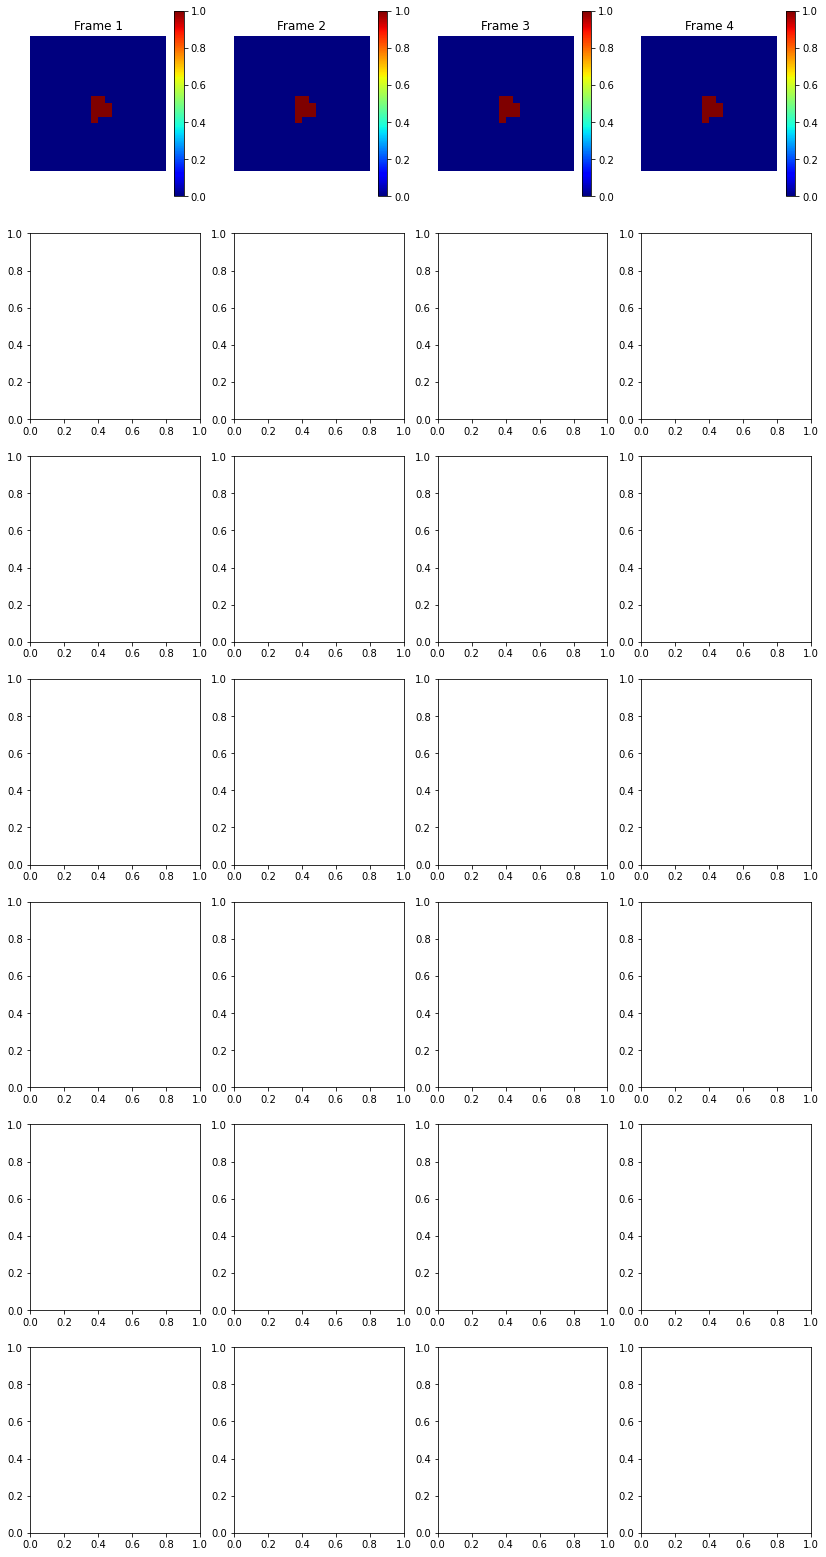

In [6]:
fig, axes = plt.subplots(7, 4, figsize=(14, 28))

data_choice = np.random.choice(range(len(x_train)), size=1)[0]
fig_ind = 1
for idx, ax in enumerate(axes.flat):
    plt.subplot(7,4,fig_ind)
    fig_ind += 1
    plt.imshow(np.squeeze(x_train[data_choice][idx][:,:,0]),cmap='jet')
    plt.title(f"Frame {idx + 1}")
    plt.axis("off")
    plt.colorbar()
    
print(f"Displaying frames for example {data_choice}.")
plt.show()

Displaying frames for example 28.


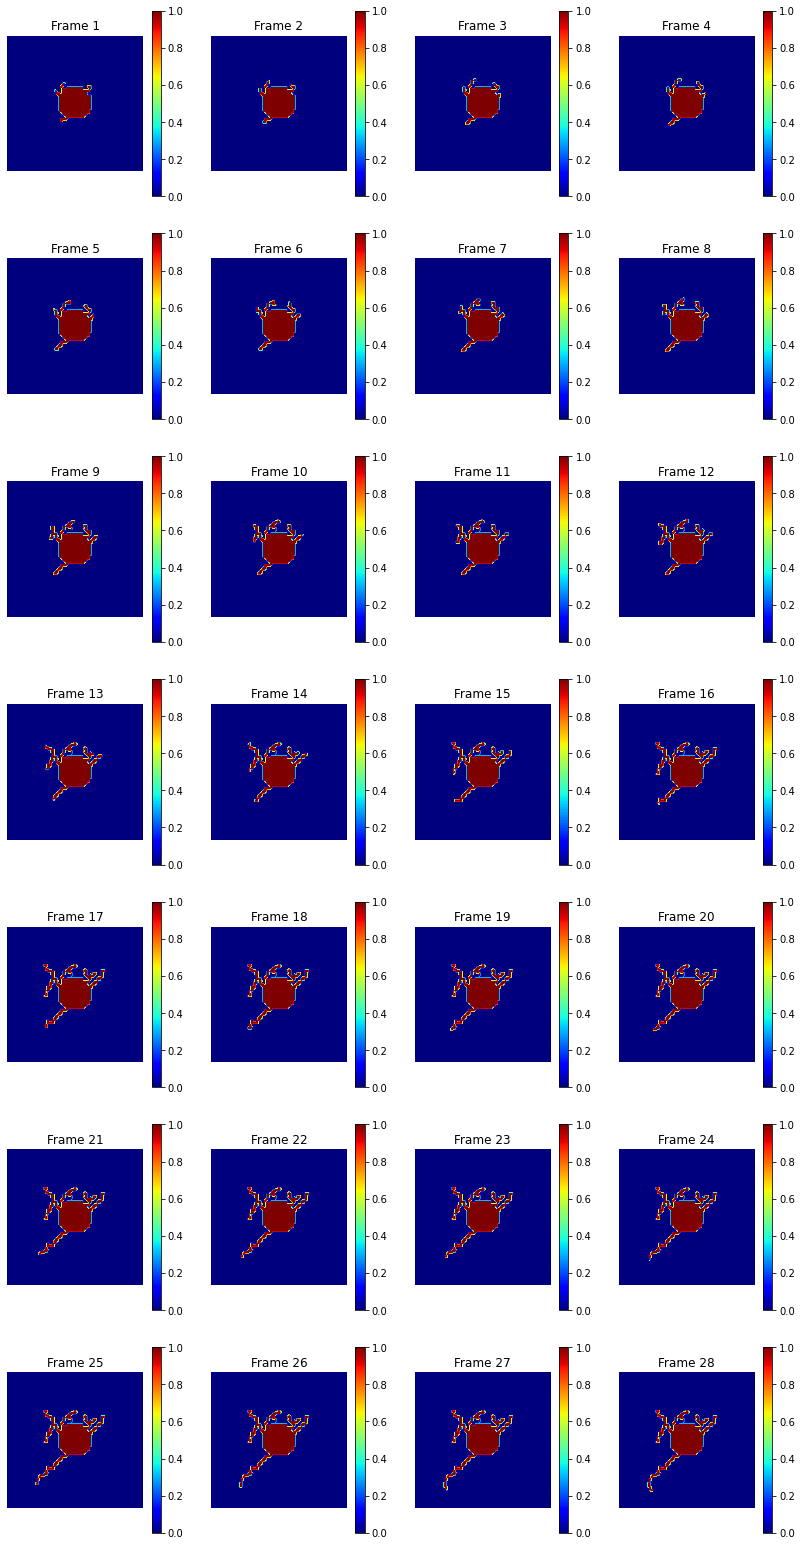

In [ ]:
fig, axes = plt.subplots(7, 4, figsize=(14, 28))

fig_ind = 1
for idx, ax in enumerate(axes.flat):
    plt.subplot(7,4,fig_ind)
    fig_ind += 1
    plt.imshow(np.squeeze(y_train[data_choice][idx][:,:,0]),cmap='jet')
    plt.title(f"Frame {idx + 1}")
    plt.axis("off")
    plt.colorbar()
    
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [ ]:
# inp = layers.Input(shape=(None, *x_train.shape[2:]))

# drop_rate = 0.1
# x0 = layers.TimeDistributed(layers.Conv2D(
#     filters=64,
#     kernel_size=(5, 5),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(inp)
# x0 = layers.Dropout(drop_rate)(x0)
# x1 = layers.TimeDistributed(layers.Conv2D(
#     filters=128,
#     kernel_size=(5, 5),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(x0)
# x1 = layers.Dropout(drop_rate)(x1)
# x2 = layers.ConvLSTM2D(
#     filters=128,
#     kernel_size=(5, 5),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
#     recurrent_dropout=drop_rate,
# )(x1)
# x3 = layers.Concatenate(axis=4)([x1,x2])
# x4 = layers.TimeDistributed(layers.Conv2DTranspose(
#     filters=64,
#     kernel_size=(6, 6),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(x3)
# x4 = layers.Dropout(drop_rate)(x4)
# x5 = layers.Concatenate(axis=4)([x0,x4])
# x6 = layers.TimeDistributed(layers.Conv2DTranspose(
#     filters=1,
#     kernel_size=(6, 6),
#     strides = (2, 2),
#     padding="valid",
#     activation="sigmoid",
# ))(x5)
# x6 = layers.Dropout(drop_rate)(x6)

In [ ]:
def sum_filter_python(phi):
    phi = phi.numpy()
    Nx = phi.shape[0]
    Ny = phi.shape[1]
    phi = np.round(phi)

    phi_sum = np.zeros([Nx,Ny])
    for i in range(5,Nx-4):
        for k in range(5,Ny-4):
            for j in range(k-4,k+4+1):
                phi_sum[i,k] = phi_sum[i,k] + int(phi[i,k]==phi[i-4,j])*phi[i-4,j] + int(phi[i,k]==phi[i-3,j])*phi[i-3,j] + int(phi[i,k]==phi[i-2,j])*phi[i-2,j] + int(phi[i,k]==phi[i-1,j])*phi[i-1,j] + int(phi[i,k]==phi[i-0,j])*phi[i,j] + int(phi[i,k]==phi[i+1,j])*phi[i+1,j] + int(phi[i,k]==phi[i+2,j])*phi[i+2,j] + int(phi[i,k]==phi[i+3,j])*phi[i+3,j] + int(phi[i,k]==phi[i+4,j])*phi[i+4,j]

    phi_sum = np.divide(phi,phi_sum)
    phi_sum[np.isnan(phi_sum)] = 0
    phi_sum_max = np.amax(np.amax(phi_sum))
    phi_sum = np.divide(phi_sum,phi_sum_max)

    phi_sum_temp = phi_sum
    cutoff = np.percentile(np.reshape(phi_sum_temp,[Nx*Ny,1]),99.97)
    phi_sum[phi_sum<cutoff] = 0
    phi_sum[phi_sum!=1] = 0  
    out = tf.Variable(tf.zeros([Nx,Ny],tf.float64))
    out.assign(phi_sum)
    return out

def highlightZone(tip):
    [Max_y,Max_x] = np.where(tip==1)
    size_Max = len(Max_x)
    Nx, Ny = phi_plot.shape
    tips = np.zeros([Nx,Ny])
    temp = np.zeros([Nx,Ny])
    for l in range(0,size_Max):
        max_x = Max_x[l]
        max_y = Max_y[l]
        for i in range(max_y-2,max_y+2):
            for j in range(max_x-2,max_x+2):
                    temp[i,j] = 1
        tips = tips+temp

    tips[np.abs(tips)>0] = 1
    return tips

In [7]:
def sum_filter_python(phi):
    [Nx,Ny] = tf.shape(phi)
    phi = tf.math.round(phi)
    phi_sum = tf.Variable(tf.zeros([Nx,Ny],tf.float32))
    for i in range(5,Nx-4):
        for k in range(5,Ny-4):
            for j in range(k-4,k+4+1):
                phi_sum[i,k].assign(tf.math.add(tf.cast(phi[i,k],tf.float32),tf.multiply(tf.cast(phi[i,k]==phi[i-4,j],tf.float32),phi[i-4,j])))

    return phi_sum

In [30]:
import scipy.io
cm = scipy.io.loadmat('cm_20.mat')["cm"][0]
cm["NuNv"][0] = cm["NuNv"][0].todense()
cm["N1uNv"][0] = cm["N1uNv"][0].todense()
cm["NuN1v"][0] = cm["NuN1v"][0].todense()
cm["N2uNv"][0] = cm["N2uNv"][0].todense()
cm["NuN2v"][0] = cm["NuN2v"][0].todense()
cm["N2uN2v"][0] = cm["N2uN2v"][0].todense()

In [31]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))

drop_rate = 0.1
x0 = layers.TimeDistributed(layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(inp)
x1 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="sigmoid",
))(x0)

In [39]:
from keras import backend as K

def PINN_loss(cm, inp):
    def loss(y_true, y_pred):
        NuNv = cm["NuNv"][0]
        N1uNv = cm["N1uNv"][0]
        NuN1v = cm["NuN1v"][0]
        N2uNv = cm["N2uNv"][0]
        NuN2v = cm["NuN2v"][0]
        N2uN2v = cm["N2uN2v"][0]

        # need to figure the correct dt, and T_pre
        dt = 1
        T_pre = tf.cast(K.reshape(y_pred[0,0,:,:,0], [y_pred.shape[2]*y_pred.shape[3],1]), dtype=tf.float64)
        xtheta = tf.cast(K.reshape(y_pred[0,0,:,:,0], [y_pred.shape[2]*y_pred.shape[3],1]), dtype=tf.float64)
        
        phiK = tf.linalg.solve(NuNv,tf.cast(K.reshape(y_pred[0,0,:,:,0], [y_pred.shape[2]*y_pred.shape[3],1]), dtype=tf.float64))
        # error when calling tf.linalg.solve the second time, suspecting memory related issue
        phi = tf.linalg.solve(NuNv, tf.cast(K.reshape(inp[0,0,:,:,0], [y_pred.shape[2]*y_pred.shape[3],1]), dtype=tf.float64))
        # phi = phiK

        NNpk = tf.linalg.matmul(NuNv,phiK)
        NNp = tf.linalg.matmul(NuNv,phi)

        # Temperature calculation
        T = (3*tf.linalg.matmul(N2uN2v,T_pre)+4*(NNpk - NNp)/dt + T_pre)*dt

        # Energy calculation
        E = 0.2865*tf.math.atan(10*(1-T))

        # Tubulin

        # a, aap
        N1Np = tf.linalg.matmul(N1uNv,phi)
        NN1p = tf.linalg.matmul(NuN1v,phi)
        atheta = tf.math.atan2(NN1p,N1Np)
        epsilon = 0.04*(1.0+0.1*tf.math.cos(6*(atheta-xtheta)))
        epsilon_deriv = -0.04*(6*0.1*tf.math.sin(6*(atheta-xtheta)))
        aap = tf.math.multiply(epsilon,epsilon_deriv)

        # phi
        # (phiK-phi)/dt = 60*()
        residual = phiK
        return residual
    return loss

In [40]:
model = keras.models.Model(inp, x1)
model.compile(
    # loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    loss=PINN_loss(cm, inp),
    optimizer=keras.optimizers.Adam(learning_rate=1e-5))
print(model.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 20, 20, 3)  0         
                             ]                                   
                                                                 
 time_distributed_4 (TimeDis  (None, None, 8, 8, 32)   2432      
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, None, 20, 20, 1)  1153      
 tributed)                                                       
                                                                 
Total params: 3,585
Trainable params: 3,585
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 2:  # or save after some epoch, each k-th epoch etc.
            self.model.save("model_{}.hd5".format(epoch))

In [42]:
test = False

if test == True:
    model = keras.models.load_model('./saved_model/model_conv_lstm_test')
else: 
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)

    epochs = 1000
    batch_size = 1
    saver = CustomSaver()

    with tf.device('/device:GPU:0'):
        model.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val, y_val),
            callbacks=[saver,early_stopping, reduce_lr],
        )
        model.run_eagerly = True

    model.save('./saved_model/model_conv_lstm_test') 

Epoch 1/1000
1/1 [==============================] - 1s 667ms/step - loss: 0.4999 - val_loss: 0.5000 - lr: 1.0000e-05
Epoch 2/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.4999 - val_loss: 0.5000 - lr: 1.0000e-05
Epoch 3/1000
1/1 [==============================] - ETA: 0s - loss: 0.4999

INFO:tensorflow:Assets written to: model_2.hd5/assets


INFO:tensorflow:Assets written to: model_2.hd5/assets


1/1 [==============================] - 0s 453ms/step - loss: 0.4999 - val_loss: 0.5000 - lr: 1.0000e-05
Epoch 4/1000
1/1 [==============================] - 0s 22ms/step - loss: 0.4999 - val_loss: 0.5000 - lr: 1.0000e-05
Epoch 5/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.4999 - val_loss: 0.5000 - lr: 1.0000e-05
Epoch 6/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.4999 - val_loss: 0.4999 - lr: 1.0000e-05
Epoch 7/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.4998 - val_loss: 0.4999 - lr: 1.0000e-05
Epoch 8/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.4998 - val_loss: 0.4999 - lr: 1.0000e-05
Epoch 9/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.4998 - val_loss: 0.4999 - lr: 1.0000e-05
Epoch 10/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.4998 - val_loss: 0.4999 - lr: 1.0000e-05
Epoch 11/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.4998 - 

KeyboardInterrupt: 

In [ ]:
def create_shifted_frames_3to1(data):
    x1 = np.expand_dims(data[:, 1 : data.shape[1] - 3, :, :, 0]+data[:, 1 : data.shape[1] - 3, :, :, 1],4)
    x2 = np.expand_dims(data[:, 2 : data.shape[1] - 2, :, :, 0]+data[:, 2 : data.shape[1] - 2, :, :, 1],4)
    x3 = np.expand_dims(data[:, 3 : data.shape[1] - 1, :, :, 0]+data[:, 3 : data.shape[1] - 1, :, :, 1],4)
    x = np.concatenate((x1,x2,x3), axis=4)
    y = data[:, 4 : data.shape[1], :, :, 0]
    y = np.expand_dims(y,4)
    tips = data[:, 4 : data.shape[1], :, :, 1]
    tips = np.expand_dims(tips,4)
    return x,y,tips

x_val, y_val, tips_val = create_shifted_frames_3to1(val_dataset)

In [ ]:
def push(input, cutoff):
    max_input = np.amax(input)
    input[input>cutoff*max_input] = 1
    input[input<=cutoff*max_input] = 0
    return input

In [ ]:
import matlab.engine
eng = matlab.engine.start_matlab()
model = keras.models.load_model('./saved_model/model_conv_lstm', compile=False)
model.compile(loss=mreloss)

rand_case = np.random.randint((len(val_dataset)))

example_x = x_val[rand_case,...]
example_y = y_val[rand_case,...]
example_tips = tips_val[rand_case,...]

plt.figure(figsize=(16, 4), dpi=60)
plt.subplot(1,3,1)
plt.imshow(example_x[0,:,:,0], cmap='jet')
plt.title('Ground truth at frame 0')

plt.subplot(1,3,2)
plt.imshow(example_x[0,:,:,1], cmap='jet')
plt.title('Ground truth at frame 0')

plt.subplot(1,3,3)
plt.imshow(example_x[0,:,:,2], cmap='jet')
plt.title('Ground truth at frame 0')
plt.show()

x_in = np.expand_dims(np.expand_dims(example_x[0,...],axis=0),axis=0)

for i in range(example_x.shape[0]-3):
    # model = keras.models.load_model('./saved_model/model_conv_lstm')
    new_prediction = model.predict(x_in,verbose="0")
    # keras.backend.clear_session()
    temp = np.zeros([1,1,100,100,3])

    tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(new_prediction[0,0,:,:,0]).astype('float64')),5000))
    # model = keras.models.load_model('./saved_model/model_tipsCNN_predBased_mre', compile=False)
    # model.compile(loss=mreloss)
    # tips = push(model.predict(np.expand_dims(np.expand_dims(new_prediction[0,0,:,:,0],axis=0),axis=3),verbose="0"),0.5)
    # keras.backend.clear_session()
    # tips = np.round(example_tips[i,:,:,0])

    temp[0,0,:,:,0] = x_in[0,0,:,:,1]
    temp[0,0,:,:,1] = x_in[0,0,:,:,2]
    # temp[0,0,:,:,2] = np.round(new_prediction[0,0,:,:,0])+tips[0,:,:,0]
    temp[0,0,:,:,2] = np.round(new_prediction[0,0,:,:,0])+tips
    x_in = temp

    mre = np.sqrt(np.sum(np.square(new_prediction[0,0,:,:,0]-example_y[i,:,:,0])/(new_prediction.shape[2]*new_prediction.shape[3])))

    plt.figure(figsize=(16, 4), dpi=60)

    plt.subplot(1,4,1)
    plt.imshow(new_prediction[0,0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Prediction at frame %d'%(i+3))

    plt.subplot(1,4,2)
    plt.imshow(tips, cmap='jet')
    plt.colorbar()
    plt.title('Detected tips at frame %d'%(i+3))

    plt.subplot(1,4,3)
    plt.imshow(example_y[i,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Ground truth at frame %d'%(i+3))

    plt.subplot(1,4,4)
    plt.imshow(new_prediction[0,0,:,:,0]-example_y[i,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Absolute error at frame %d'%(i+3))
    plt.xlabel('Mean relative error: %f'%mre)

    plt.show()

# eng.quit()


In [ ]:
import matlab.engine
from tqdm import tqdm
eng = matlab.engine.start_matlab()

mre = []
for rand_case in tqdm (range(len(val_dataset)), desc="Running ..."):
    example_x = x_val[rand_case,...]
    example_y = y_val[rand_case,...]
    x_in = np.expand_dims(np.expand_dims(example_x[0,...],axis=0),axis=0)

    for i in range(example_x.shape[0]-3):

        new_prediction = model.predict(x_in, verbose="0")
        temp = np.zeros([1,1,100,100,3])

        # tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(new_prediction[0,0,:,:,0]).astype('float64')),5000))
        tips = np.round(example_tips[i,:,:,0])
        temp[0,0,:,:,0] = x_in[0,0,:,:,1]
        temp[0,0,:,:,1] = x_in[0,0,:,:,2]
        temp[0,0,:,:,2] = np.round(new_prediction[0,0,:,:,0])+tips

        x_in = temp

        mre.append(np.sqrt(np.sum(np.square(new_prediction[0,0,:,:,0]-example_y[i,:,:,0])/(new_prediction.shape[2]*new_prediction.shape[3]))))

print(sum(mre) / len(mre))
eng.quit()
